# Compute grads and save to file

In [ ]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from decode_tueg import (
    load_exp, DataScaler, TargetScaler, Augmenter, 
    save_csv, iter_exp_dir, get_freqs_and_info, compute_gradients,
    get_datasets,
)

Thu Feb 23 12:31:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:B1:00.0 Off |                  N/A |
| 27%   25C    P8    21W / 250W |   5050MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
batch_size = 128  # TODO: maximize batch size for faster computation
n_jobs = 4
n_recordings = None
exp_dir = '/home/jovyan/experiments/'
exp_date = '2023-02-15T18:43:26.819382'
checkpoint = 'train_end'

In [ ]:
# compute only on valid / eval?
for ds_name in ['eval_not_normal']:
    for exp_path in iter_exp_dir(exp_dir, exp_date):
        print(f'loading exp {exp_path}')
        clf, data_scaler, target_scaler, config = load_exp(
            exp_dir, exp_path, checkpoint)
        print(f'getting {ds_name}')
        # load preprocessed and windowed dataset
        if ds_name == 'eval_not_normal':
            p = f'/home/jovyan/{ds_name}_pre_win.pkl'
        else:
            p = f'/home/jovyan/longitudinal/{ds_name}_pre_win.pkl'
        with open(p, 'rb') as f:
            ds = pickle.load(f)
        1/0
        if n_recordings not in [-1, None]:
            ds = ds.split(list(range(n_recordings)))['0']
        print('computing gradients')
        grads = compute_gradients(clf, ds, batch_size, n_jobs)
        # create grads output subdir
        out_path = os.path.join(exp_dir, exp_path, 'grads')
        print(f'saving {out_path}')
        if not os.path.exists(out_path):
            os.makedirs(out_path)
        save_csv(grads, out_path, f'{checkpoint}_{ds_name}_grads.csv')
        #break
    #break

loading exp 2023-02-22T12:51:02.928667/20230214/0


KeyboardInterrupt: 

In [ ]:
print("HI")

# Read grads from files and plot

In [4]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
import numpy as np
import pandas as pd
from decode_tueg import (
    plot_band_grads, freqs_to_bin, iter_exp_dir, make_info)

In [5]:
exp_dir = '/home/jovyan/experiments/'
exp_date = '2023-02-15T18:43:26.819382'
exp_date = '2023-02-22T12:51:02.928667'  # !
checkpoint = 'train_end'

In [6]:
# 0,4 
bands = [(0,4),(4,8),(8,13),(13,30),(30,50)]

In [7]:
ds_names = ['eval', 'eval_not_normal']
ds_names = ['valid']

In [8]:
all_grads = []
for ds_name in ds_names:
    for exp_path in iter_exp_dir(exp_dir, exp_date):
        print(exp_path)
        grads = pd.read_csv(os.path.join(exp_dir, exp_path, 'grads', f'{checkpoint}_{ds_name}_grads.csv'), index_col=0)
        all_grads.append(grads)
all_grads = pd.concat(all_grads).reset_index().groupby(['index', 'pathological'], as_index=False).mean().set_index('index')

2023-02-22T12:51:02.928667/20230214/0


In [9]:
all_grads.groupby('pathological').max().max(axis=1)

pathological
False    4.125606e-08
True     3.447568e-08
dtype: float64

In [10]:
all_grads.groupby('pathological').min().min(axis=1)

pathological
False   -4.762537e-08
True    -2.714193e-08
dtype: float64

In [11]:
all_grads.groupby('pathological').mean().mean(axis=1)

pathological
False   -3.957601e-11
True    -3.317549e-10
dtype: float64

In [12]:
grads = all_grads

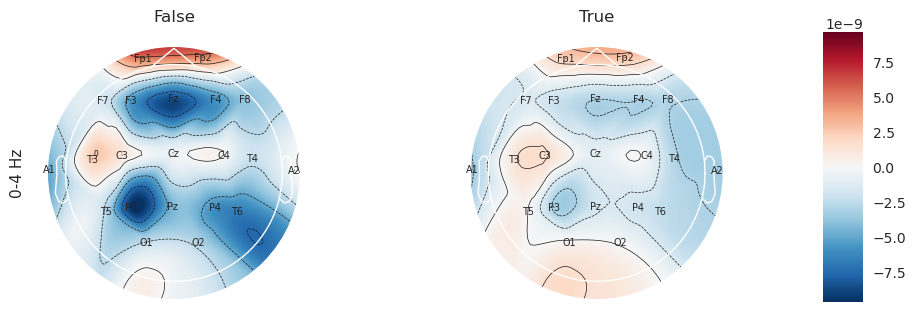

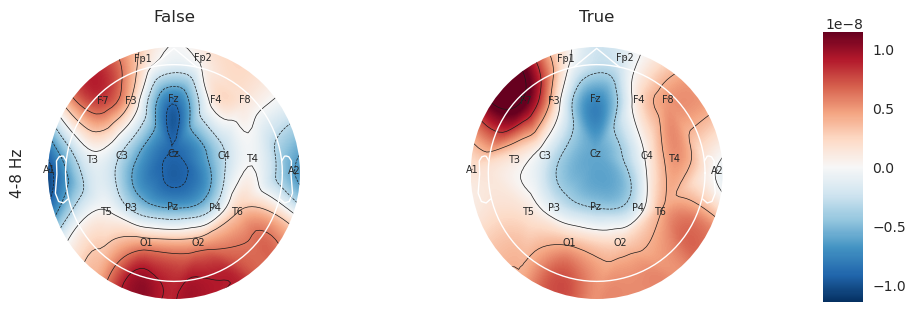

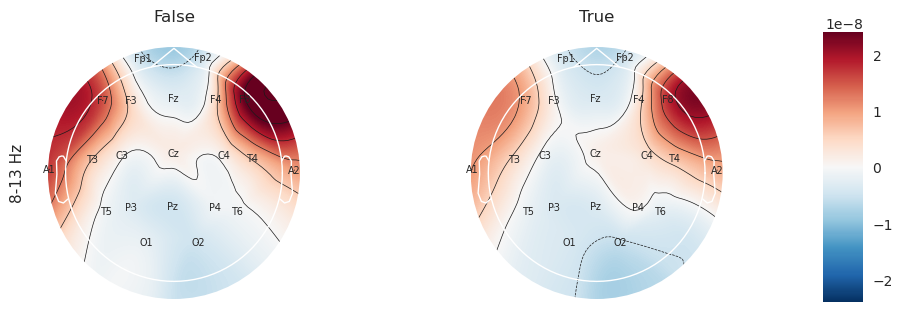

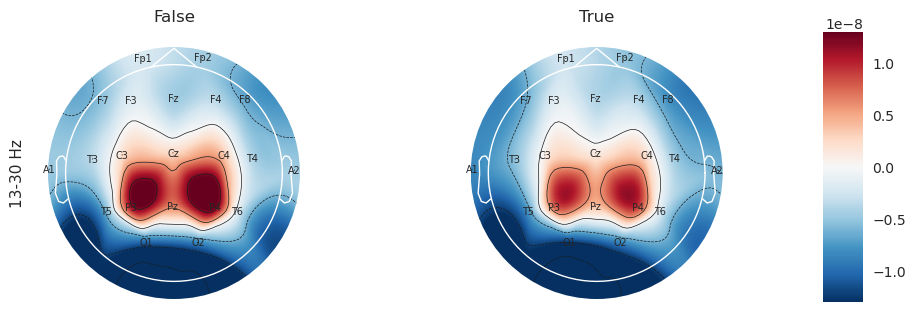

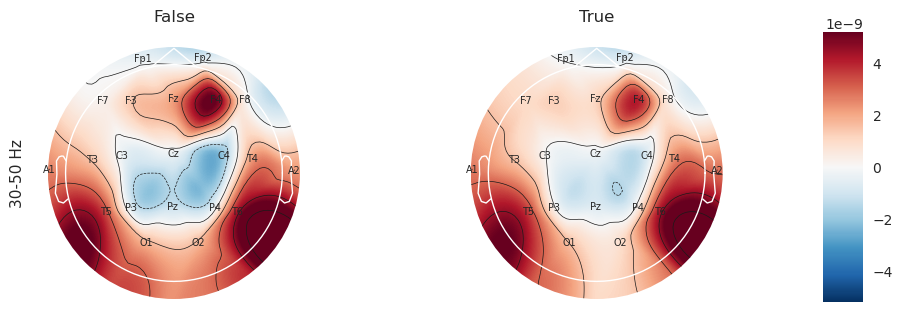

In [13]:
all_band_grads = {}
for band in bands:
    all_band_grads[band] = {}
    for pathological, g in grads.groupby('pathological'):
        g.drop('pathological', inplace=True, axis=1)
        names = list(g.index)
        freqs = np.array([float(f) for f in g.columns])
        g = g.values

        l, h = freqs_to_bin(freqs, band)
        band_freqs = freqs[l:h+1]
        band_grads = g[:,l:h+1].mean(axis=1)
        all_band_grads[band][pathological] = band_grads
    #if 0 in all_band_grads[band].keys() and 1 in all_band_grads[band].keys():
    #    all_band_grads[band][-1] = all_band_grads[band][0] - all_band_grads[band][1]
    # TODO: rename again from 0, 1, -1 to patho, non-patho, diff
    fig = plot_band_grads(all_band_grads[band], make_info(names), band, False)

In [14]:
to_plot = {False: {}, True: {}}
for band, subset_band_grads in all_band_grads.items():
    for pathological, band_grads in subset_band_grads.items():
        print(band, pathological)
        to_plot[pathological][band] = band_grads

(0, 4) False
(0, 4) True
(4, 8) False
(4, 8) True
(8, 13) False
(8, 13) True
(13, 30) False
(13, 30) True
(30, 50) False
(30, 50) True


In [ ]:
fig = plot_band_grads(to_plot[False], make_info(names), [False], True)

In [ ]:
fig = plot_band_grads(to_plot[True], make_info(names), [True], True)